# Data Exploration
> ETL - Data exploration is the process of examining and visualizing your data before modeling. It helps you understand the structure, patterns, distributions, and potential issues (like missing values or outliers) in your dataset. This step guides data cleaning, feature engineering, and model selection by revealing important insights about the data.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data

In [2]:
input_folder = "../.local/analysis_pipeline/data_etl"
model_data = pd.read_parquet(f"{input_folder}/model_data.parquet")
print( model_data.shape )
model_data.head(5)

(60392, 19)


,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium,agecat2,pol_year,pol_quarter,veh_cnt
0,64080188,2017-07-10,M,2.0,1989-01-04,631.0,B,140.9,4,TRUCK,0.924,None,0,0.000000,716.53,5.0,2017,3,1
1,18917133,2017-07-31,M,2.0,1985-06-21,531.0,C,136.5,3,HBACK,1.430,B,1,583.010876,716.53,5.0,2017,3,1
2,82742606,2017-02-01,M,6.0,1942-07-25,838.0,D,88.8,3,SEDAN,1.100,D,1,159.375757,716.53,1.0,2017,1,1
3,43601997,2017-10-17,M,5.0,1959-06-08,835.0,E,NaN,2,SEDAN,2.090,None,0,0.000000,716.53,2.0,2017,4,1
4,58746861,2017-04-13,F,4.0,1967-05-16,748.0,C,123.0,3,HBACK,0.803,C,1,143.555642,716.53,3.0,2017,2,1


In [3]:
inference_data = pd.read_parquet(f"{input_folder}/inference_data.parquet")
print( inference_data.shape )
inference_data.head(5)

(7464, 13)


,quote_number,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,agecat2,veh_cnt,pol_year
0,29323463,F,4.0,1968-04-14,750.0,C,124.5,2,HBACK,1.100,3.0,1,2018
1,16732441,M,2.0,1984-10-04,567.0,F,NaN,3,STNWG,2.079,5.0,1,2018
2,68744228,M,4.0,1962-11-30,378.0,D,111.4,3,HDTOP,2.354,3.0,1,2018
3,30875047,F,3.0,1973-05-17,807.0,E,NaN,4,UTE,1.969,4.0,1,2018
4,37049210,M,6.0,1945-10-02,844.0,C,111.0,1,HBACK,1.969,1.0,1,2018


## Target Variable Analysis
### Create target variable

In [4]:
# Rename columns for clarity and consistency
model_data = model_data.rename(columns={'numclaims': 'claim_cnt'})
model_data = model_data.rename(columns={'claimcst0': 'claim_amt'})

# Create a new column 'claim_sev' (claim severity) as claim_amt divided by claim_cnt
# If claim_cnt is zero, set claim_sev to NaN to avoid division by zero
model_data['claim_sev'] = model_data.apply(
    lambda row: row['claim_amt'] / row['claim_cnt'] if row['claim_cnt'] != 0 else np.nan,
    axis=1
)

### Visualize target variables
#### Visualize claim count/frequency variable

Mean of claim_cnt: 0.214
Variance of claim_cnt: 0.305


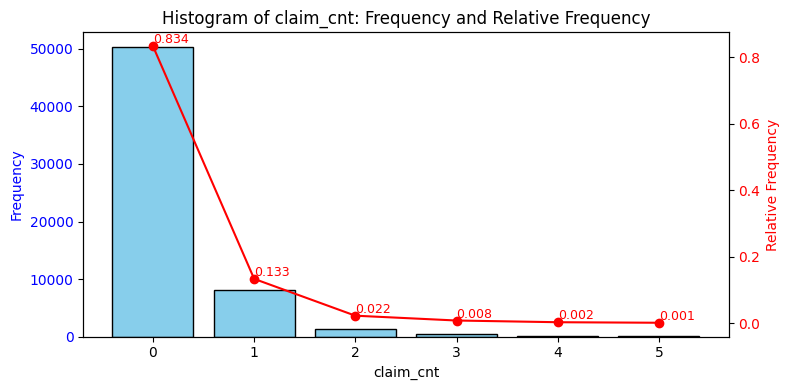

In [5]:
# Plot a histogram of 'claim_cnt' showing both frequency and relative frequency, with annotations
import matplotlib.pyplot as plt
import numpy as np

# Print the mean and variance of the claim_cnt column
mean_claim_cnt = model_data['claim_cnt'].mean()
var_claim_cnt = model_data['claim_cnt'].var()
print(f"Mean of claim_cnt: {mean_claim_cnt:.3f}")
print(f"Variance of claim_cnt: {var_claim_cnt:.3f}")

# Show the claim count distribution
counts, bins = np.histogram(model_data['claim_cnt'], bins=range(int(model_data['claim_cnt'].min()), int(model_data['claim_cnt'].max())+2))
rel_freq = counts / counts.sum()

fig, ax1 = plt.subplots(figsize=(8,4))

# Frequency histogram
ax1.bar(bins[:-1], counts, width=0.8, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('claim_cnt')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Relative frequency (secondary axis)
ax2 = ax1.twinx()
ax2.plot(bins[:-1], rel_freq, 'o-', color='red', label='Relative Frequency')
ax2.set_ylabel('Relative Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate relative frequency values next to red dots
for x, y in zip(bins[:-1], rel_freq):
    ax2.text(x, y, f'{y:.3f}', color='red', fontsize=9, ha='left', va='bottom')

plt.title('Histogram of claim_cnt: Frequency and Relative Frequency')
fig.tight_layout()
plt.show()

#### Visualize claim severity

Gamma Distribution: Kurtosis and Mean-Variance Relationship
- **Kurtosis**: The excess kurtosis of a Gamma distribution with shape parameter $k$ is $6/k$. The total kurtosis is $6/k + 3$.
- **Mean and Variance**: For shape $k$ and scale $\theta$:
    - Mean: $\mu = k\theta$
    - Variance: $\sigma^2 = k\theta^2$
    - So, $\text{Variance} = \text{Mean} \times \theta$

Mean of claim_sev: 3073.604
Variance of claim_sev: 34498627.299
Skewness of claim_sev: 4.979
Kurtosis of claim_sev: 33.045


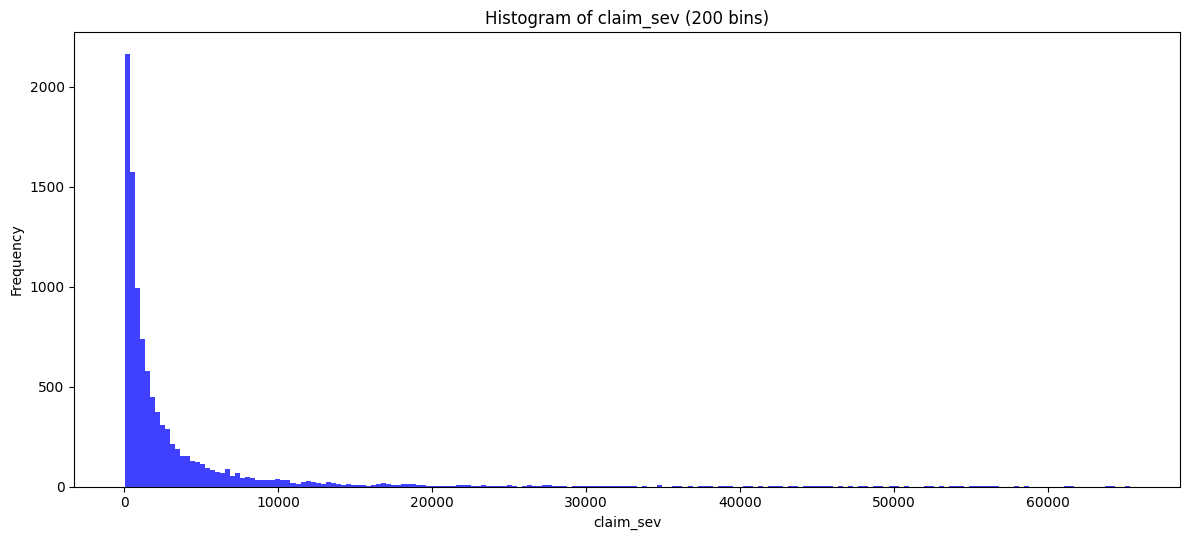

In [6]:
# Compute mean, variance, skewness, and kurtosis of claim_sev
mean_sev = model_data['claim_sev'].dropna().mean()
var_sev = model_data['claim_sev'].dropna().var()
skew_sev = model_data['claim_sev'].dropna().skew()
kurt_sev = model_data['claim_sev'].dropna().kurtosis()
print(f"Mean of claim_sev: {mean_sev:.3f}")
print(f"Variance of claim_sev: {var_sev:.3f}")
print(f"Skewness of claim_sev: {skew_sev:.3f}")
print(f"Kurtosis of claim_sev: {kurt_sev:.3f}")

# Plot a histogram of 'claim_sev' with 100 bins
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5.5))
plt.hist(model_data['claim_sev'].dropna(), bins=200, facecolor='blue', alpha=0.75)
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

Cap severity variable

Kurtosis of original claim_sev: 33.028
Kurtosis of capped claim_sev: 23.228
After capping at the 99.5 percentile (cap value: 44000.0), the % of total capped claim_sev to the total original claim_sev is 98.6%.


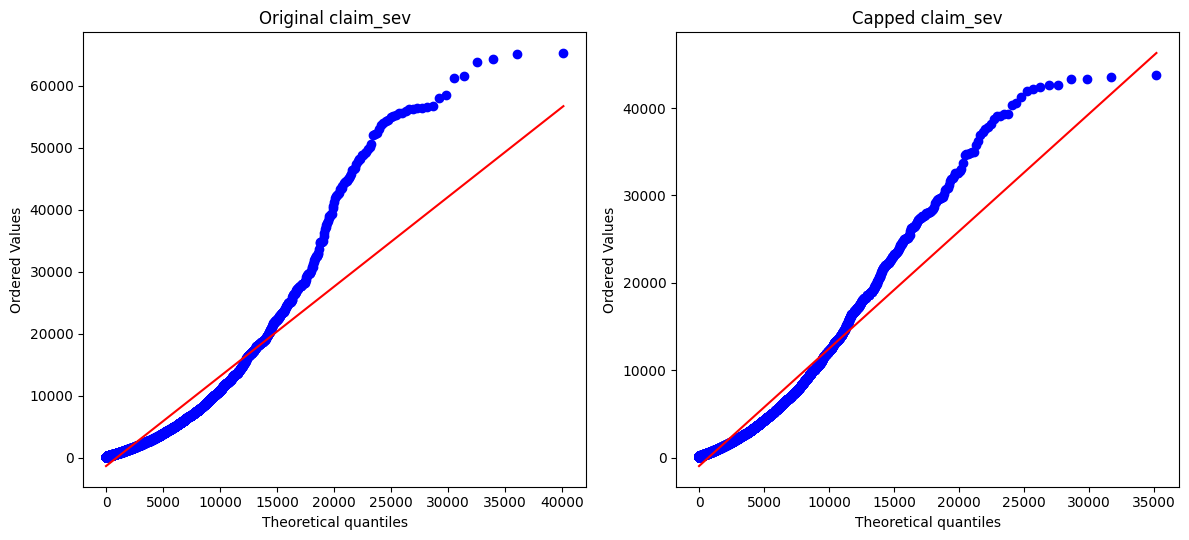

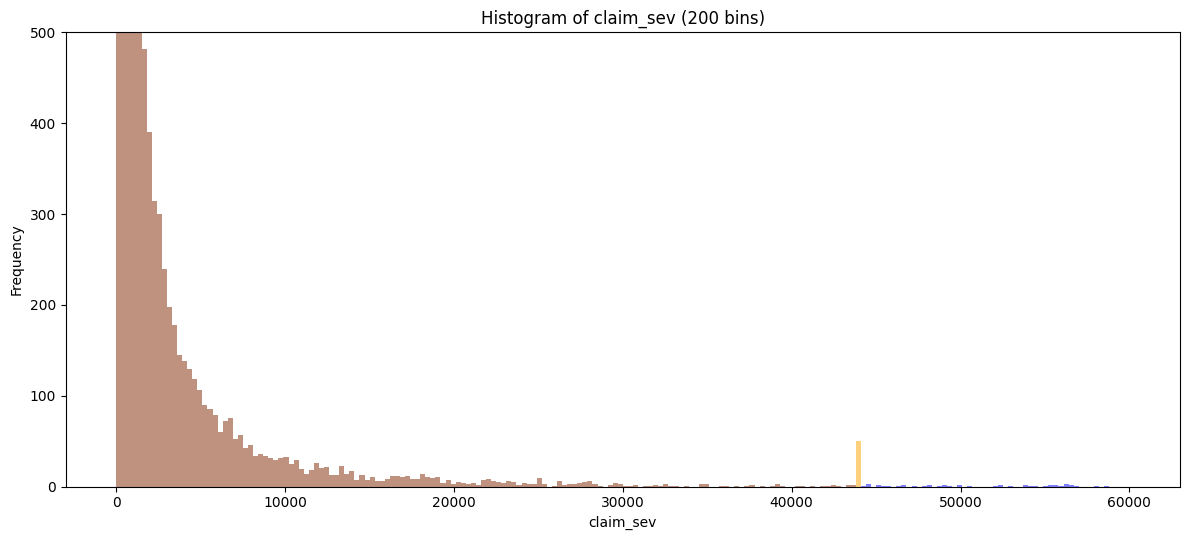

In [7]:
# QQ plot for claim_sev before and after capping at a specified percentile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.pylab import rcParams

# Set capping percentile and calculate cap value
cap_percentile = 99.5
cap_value = 1000 * round(np.nanpercentile(model_data['claim_sev'], cap_percentile) / 1000, 0)

# Cap the claim_sev variable
model_data['claim_sev_capped'] = model_data['claim_sev'].clip(upper=cap_value)

# Calculate share of capped to original
share_incurred = model_data['claim_sev_capped'].sum() / model_data['claim_sev'].sum()

# Print kurtosis and share information
print(f"Kurtosis of original claim_sev: {stats.kurtosis(model_data['claim_sev'].dropna()):.3f}")
print(f"Kurtosis of capped claim_sev: {stats.kurtosis(model_data['claim_sev_capped'].dropna()):.3f}")
print(f"After capping at the {cap_percentile} percentile (cap value: {cap_value}), the % of total capped claim_sev to the total original claim_sev is {100 * share_incurred:.1f}%.")

# Prepare data for QQ plots
y_ori = model_data['claim_sev'].dropna()
y_capped = model_data.loc[model_data['claim_sev']<=cap_value, 'claim_sev_capped'].dropna()

# Fit gamma distributions
sparams_ori = stats.gamma.fit(y_ori, floc=0)
sparams_capped = stats.gamma.fit(y_capped, floc=0)

# Plot QQ plots
rcParams['figure.figsize'] = 12, 5.5
fig, (ax1, ax2) = plt.subplots(1, 2)
stats.probplot(y_ori, sparams_ori, dist='gamma', plot=ax1)
ax1.set_title('Original claim_sev')
stats.probplot(y_capped, sparams_capped, dist='gamma', plot=ax2)
ax2.set_title('Capped claim_sev')
plt.tight_layout()
plt.show()

# Plot a histogram of 'claim_sev' and 'claim_sev_capped' with 200 bins
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12, 5.5
plt.hist(model_data['claim_sev'].dropna(), bins=200, range=[0, 60000], facecolor='blue', alpha=0.5, label='Original')
plt.hist(model_data['claim_sev_capped'].dropna(), bins=200, range=[0, 60000], facecolor='orange', alpha=0.5, label='Capped')
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.ylim([0,500])
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

#### Compute total claim amount

In [8]:
# Compute the capped claim amount
model_data['claim_amt_capped'] = model_data.apply(
    lambda row: row['claim_cnt'] * row['claim_sev_capped'] if row['claim_cnt']!=0 else 0, 
    axis=1
)

# Print the total original and capped claim amounts
print(f"Average original claim amount: {model_data['claim_amt'].mean():.3f}")
print(f"Average capped claim amount: {model_data['claim_amt_capped'].mean():.3f}")
# Print the combined original and capped loss ratios
print(f"Combined original loss ratio: {model_data['claim_amt'].sum() / model_data['annual_premium'].sum():.3f}")
print(f"Combined capped loss ratio: {model_data['claim_amt_capped'].sum() / model_data['annual_premium'].sum():.3f}")

Average original claim amount: 644.876
Average capped claim amount: 637.706
Combined original loss ratio: 0.900
Combined capped loss ratio: 0.890


## Split Data

In [28]:
# Add a 'fold' column with random assignment of 1,2,3,4 to each row, using a fixed random seed
np.random.seed(42)  # Fix the random seed for reproducibility
model_data['fold'] = np.random.choice([1, 2, 3, 4], size=len(model_data))
rich.print(model_data['fold'].value_counts())

# Create a 'sample' column based on the 'fold' column
model_data['sample'] = np.where(model_data['fold'].isin([1,2,3]), '1|bld', '2|val')
rich.print(model_data['sample'].value_counts())

fold
1    15188
4    15092
3    15079
2    15033
Name: count, dtype: int64

sample
1|bld    45300
2|val    15092
Name: count, dtype: int64

## Consistency Check
### Create a combined data set for consistency check purpose

In [9]:
# Create predictor list
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']
cols = ['pol_year', 'veh_cnt'] + pred_lst

# Concatenate model_data[cols] and inference_data[cols] vertically
combined_expo_pred_data = pd.concat(
    [model_data[cols], 
     inference_data[cols]], 
     axis=0, 
     ignore_index=True
     )
print('Combined data shape:', combined_expo_pred_data.shape)
combined_expo_pred_data.head()

Combined data shape: (67856, 10)


,pol_year,veh_cnt,agecat2,gender,credit_score,area,traffic_index,veh_age,veh_body,veh_value
0,2017,1,5.0,M,631.0,B,140.9,4,TRUCK,0.924
1,2017,1,5.0,M,531.0,C,136.5,3,HBACK,1.430
2,2017,1,1.0,M,838.0,D,88.8,3,SEDAN,1.100
3,2017,1,2.0,M,835.0,E,NaN,2,SEDAN,2.090
4,2017,1,3.0,F,748.0,C,123.0,3,HBACK,0.803



--- Consistency Plot for agecat2 ---


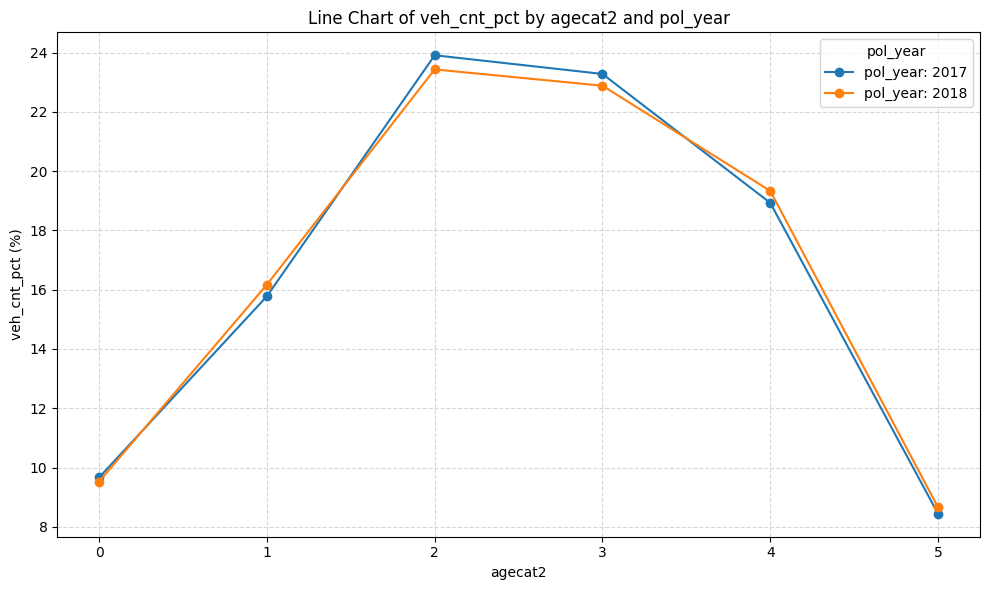


--- Consistency Plot for gender ---


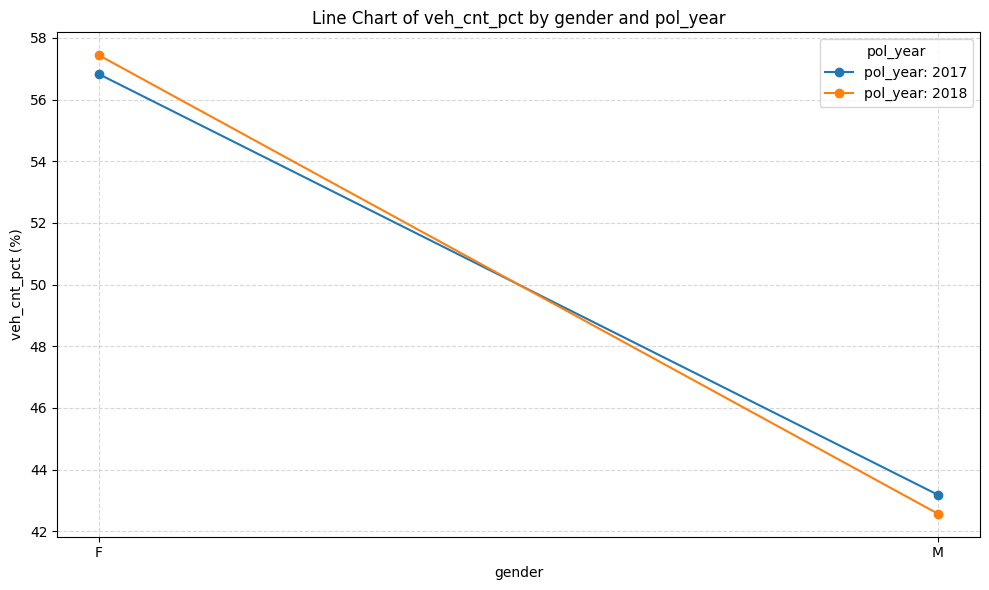


--- Consistency Plot for credit_score ---


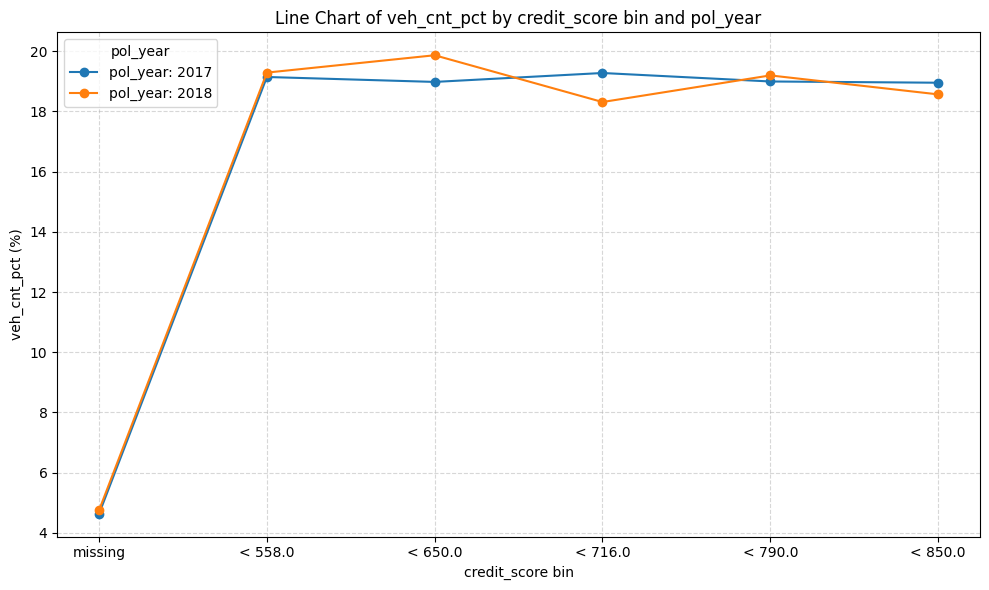


--- Consistency Plot for area ---


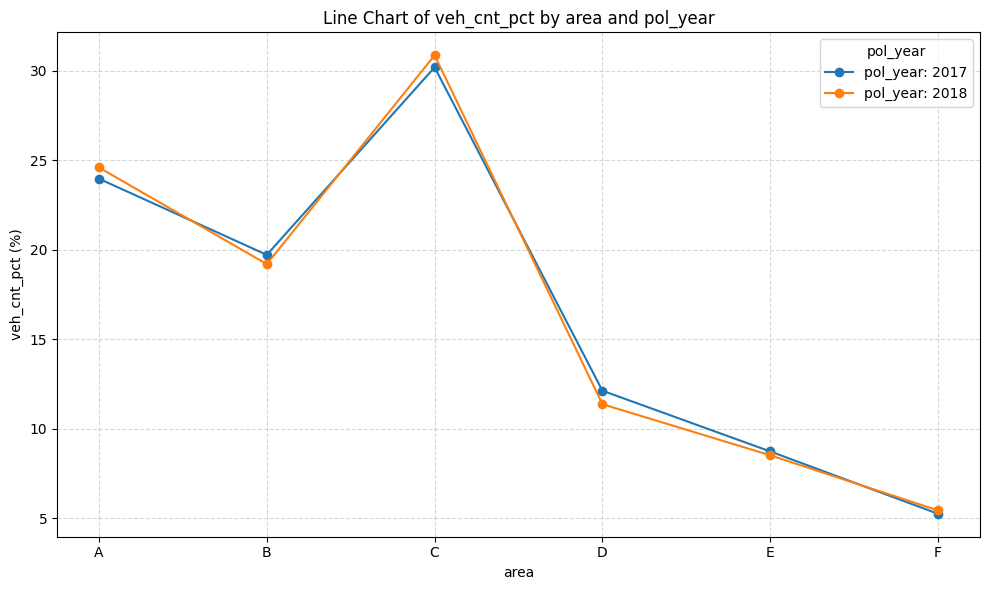


--- Consistency Plot for traffic_index ---


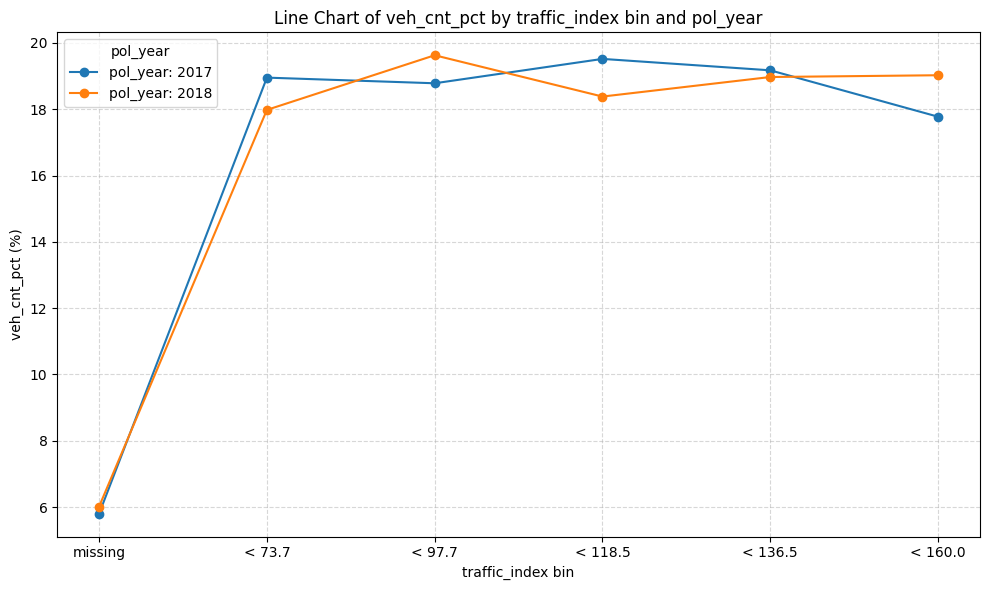


--- Consistency Plot for veh_age ---


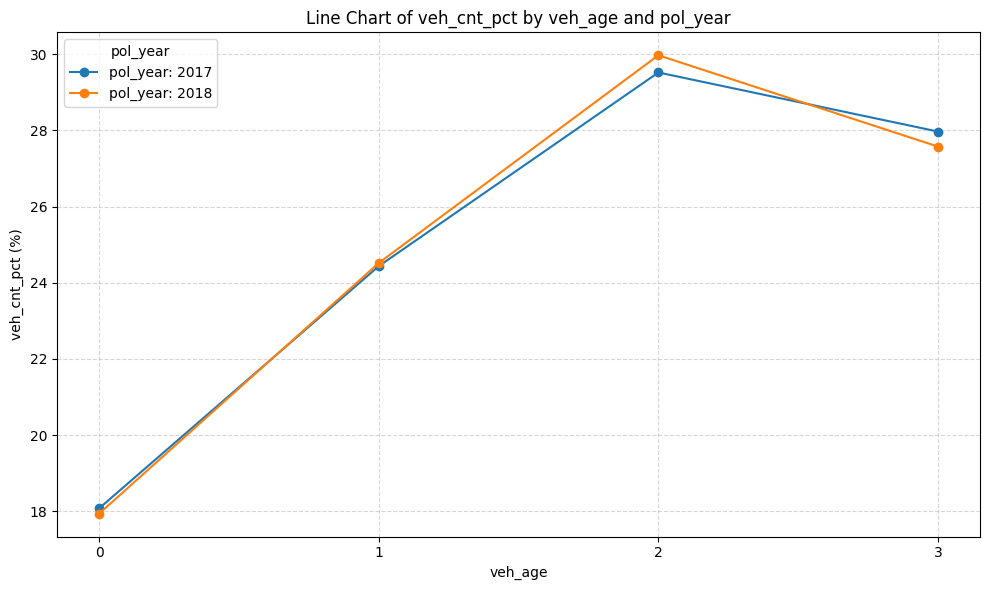


--- Consistency Plot for veh_body ---


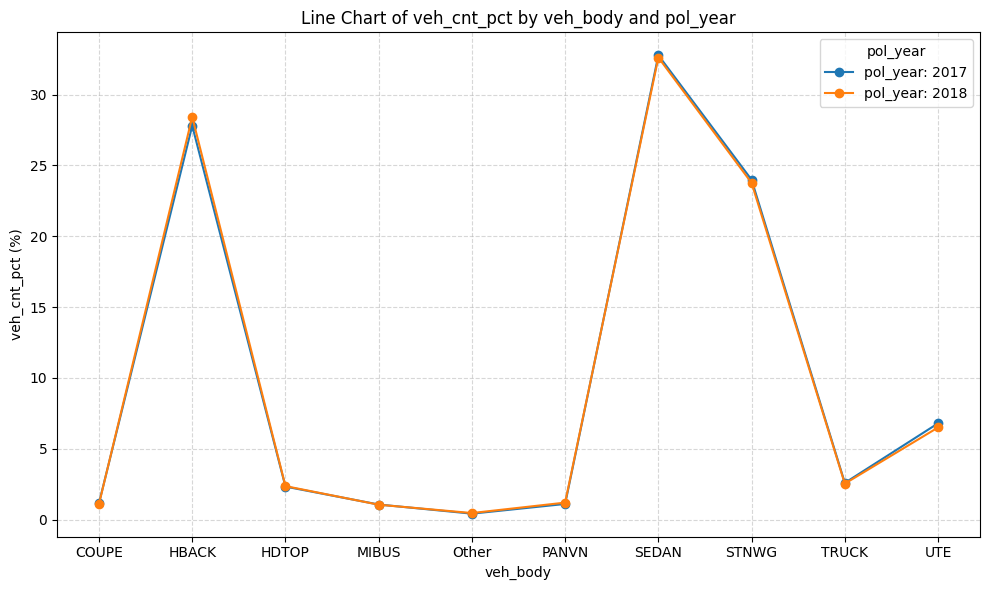


--- Consistency Plot for veh_value ---


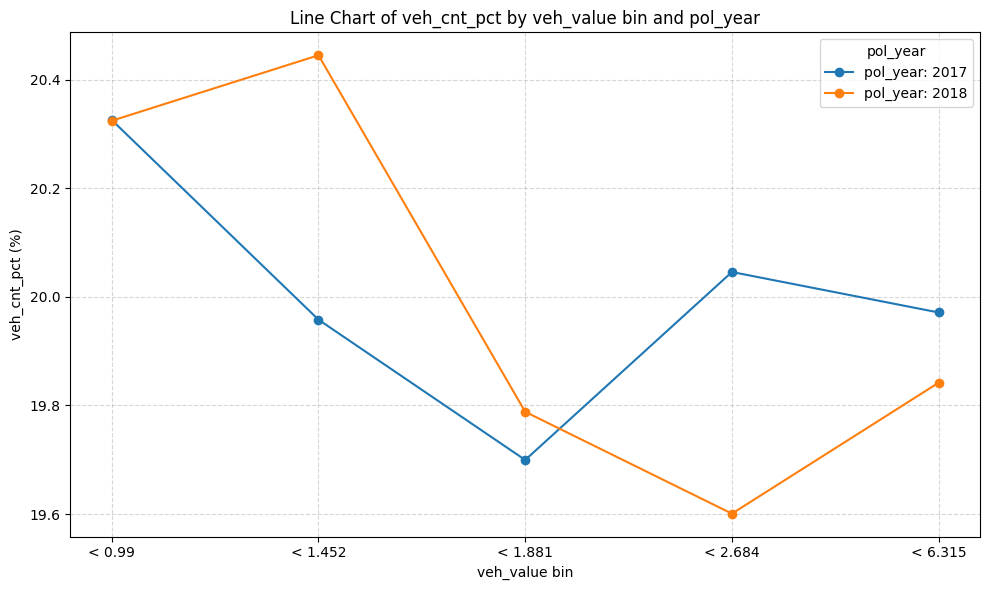

In [10]:
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import ConsistencyCheckList

ccl = ConsistencyCheckList(
    data=combined_expo_pred_data, 
    pred_var_lst=pred_lst, 
    expo_var='veh_cnt', 
    year_var='pol_year')
ccl.run_all()
ccl.plot_all()

## Predictiveness Check

In [11]:
model_data.head(5)

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,...,claim_cnt,claim_amt,annual_premium,agecat2,pol_year,pol_quarter,veh_cnt,claim_sev,claim_sev_capped,claim_amt_capped
0,64080188,2017-07-10,M,2.0,1989-01-04,631.0,B,140.9,4,TRUCK,...,0,0.000000,716.53,5.0,2017,3,1,NaN,NaN,0.000000
1,18917133,2017-07-31,M,2.0,1985-06-21,531.0,C,136.5,3,HBACK,...,1,583.010876,716.53,5.0,2017,3,1,583.010876,583.010876,583.010876
2,82742606,2017-02-01,M,6.0,1942-07-25,838.0,D,88.8,3,SEDAN,...,1,159.375757,716.53,1.0,2017,1,1,159.375757,159.375757,159.375757
3,43601997,2017-10-17,M,5.0,1959-06-08,835.0,E,NaN,2,SEDAN,...,0,0.000000,716.53,2.0,2017,4,1,NaN,NaN,0.000000
4,58746861,2017-04-13,F,4.0,1967-05-16,748.0,C,123.0,3,HBACK,...,1,143.555642,716.53,3.0,2017,2,1,143.555642,143.555642,143.555642


In [74]:
# Example: multiply by 1.1 and add normal noise with mean 0 and std 100
model_data['pesudo_pred_claim_amt_capped'] = (
    model_data['claim_amt_capped'] * 1.1 +
    np.random.normal(loc=0, scale=100, size=len(model_data))
)

In [75]:
data = model_data.loc[model_data['sample'] == '1|bld']
pred_var = 'veh_value'
exp_var = 'veh_cnt'
var_1 = 'claim_amt_capped'
var_2 = 'pesudo_pred_claim_amt_capped'

from analysis_tool_chest.data_exploration import ConsistencyCheck

pc = ConsistencyCheck(
    data = data,
    pred_var =  'veh_value',
    exp_var = 'veh_cnt'
)

pc.binning()
binned_data = pc.binned_data

In [91]:
def aggregate(df, var_1, exp_var, var_2=None, pred_var=None):
    """
    Aggregate binned data by 'bin', summing specified variables and computing ratios.

    Handles three cases:
    1. Numeric variable with enough unique values (is_numeric and not treat_as_cat)
    2. Numeric variable with low cardinality (is_numeric and treat_as_cat)
    3. Categorical variable (is_numeric == False)
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'bin' column and variables to aggregate.
        var_1 (str): Name of the first variable to sum and use in ratio calculation.
        exp_var (str): Name of the exposure variable to sum and use as denominator in ratios.
        var_2 (str, optional): Name of the second variable to sum and use in ratio calculation. Default is None.
        pred_var (str, optional): Name of the predictor variable (for bin label mapping, required for treat_as_cat/categorical).
    Returns:
        pd.DataFrame: Aggregated DataFrame with sums and ratios by bin, and bin labels.
    """
    import numpy as np
    
    is_numeric = np.issubdtype(df['bin'].dtype, np.number)
    n_unique = df[pred_var].nunique(dropna=True)
    treat_as_cat = is_numeric and n_unique < 20
    
    group_cols = ['bin']
    agg_dict = {var_1: 'sum', exp_var: 'sum'}
    if var_2 is not None and var_2 in df.columns:
        agg_dict[var_2] = 'sum'
    
    if is_numeric and not treat_as_cat:
        # Numeric variable with enough unique values: aggregate by bin
        agg_df = df.groupby(group_cols, as_index=False).agg(agg_dict)
        agg_df[f'{var_1}_over_{exp_var}'] = agg_df[var_1] / agg_df[exp_var]
        if var_2 is not None and var_2 in agg_df.columns:
            agg_df[f'{var_2}_over_{exp_var}'] = agg_df[var_2] / agg_df[exp_var]
        # Add min/max of pred_var for each bin if available
        if pred_var is not None and pred_var in df.columns:
            bin_stats = df[df['bin'] != -1].groupby('bin')[pred_var].agg(['min', 'max']).reset_index()
            bin_stats = bin_stats.rename(columns={'min': f'{pred_var}_min', 'max': f'{pred_var}_max'})
            agg_df = agg_df.merge(bin_stats, on='bin', how='left')
        # Set bin_label: missing bin (-1) as 'missing', others as just the value (3 decimals)
        if pred_var is not None and f'{pred_var}_max' in agg_df.columns:
            def make_label(row):
                if row['bin'] == -1:
                    return 'missing'
                else:
                    return f"{row[f'{pred_var}_max']:.3f}"
            agg_df['bin_label'] = agg_df.apply(make_label, axis=1)
        else:
            agg_df['bin_label'] = agg_df['bin'].astype(str)
    elif treat_as_cat:
        # Numeric variable with low cardinality: treat as categorical
        agg_df = df.groupby(group_cols, as_index=False).agg(agg_dict)
        agg_df[f'{var_1}_over_{exp_var}'] = agg_df[var_1] / agg_df[exp_var]
        if var_2 is not None and var_2 in agg_df.columns:
            agg_df[f'{var_2}_over_{exp_var}'] = agg_df[var_2] / agg_df[exp_var]
        # Map bin to value using pred_var
        if pred_var is not None and pred_var in df.columns:
            unique_vals = np.sort(df[pred_var].dropna().unique())
            bin_to_val = {i: v for i, v in enumerate(unique_vals)}
            agg_df['bin_label'] = agg_df['bin'].map(bin_to_val).astype(str)
        else:
            agg_df['bin_label'] = agg_df['bin'].astype(str)
    else:
        # Categorical variable: use bin as label
        agg_df = df.groupby(group_cols, as_index=False).agg(agg_dict)
        agg_df[f'{var_1}_over_{exp_var}'] = agg_df[var_1] / agg_df[exp_var]
        if var_2 is not None and var_2 in agg_df.columns:
            agg_df[f'{var_2}_over_{exp_var}'] = agg_df[var_2] / agg_df[exp_var]
        agg_df['bin_label'] = agg_df['bin'].astype(str)
    
    return agg_df

In [92]:
# Example usage:
# var_1 = 'claim_amt_capped'
# var_2 = 'pesudo_pred_claim_amt_capped' (optional)
# exp_var = 'veh_cnt'
agg_df = aggregate(df=binned_data, var_1=var_1, exp_var=exp_var, var_2=var_2, pred_var=pred_var)
agg_df

,bin,claim_amt_capped,veh_cnt,pesudo_pred_claim_amt_capped,claim_amt_capped_over_veh_cnt,pesudo_pred_claim_amt_capped_over_veh_cnt,veh_value_min,veh_value_max,bin_label
0,0,1.871038e+06,9069,2.059575e+06,206.311404,227.100529,0.000,0.979,0.979
1,1,3.195845e+06,9134,3.507201e+06,349.884552,383.972105,0.990,1.452,1.452
2,2,5.000766e+06,9063,5.492415e+06,551.778243,606.026102,1.463,1.892,1.892
3,3,6.842262e+06,9028,7.527939e+06,757.893458,833.843477,1.903,2.695,2.695
4,4,1.235440e+07,9006,1.359018e+07,1371.796858,1509.013586,2.706,6.315,6.315


In [93]:
def plot_agg_df(agg_df, pred_var, exp_var, var_1, var_2=None, color_1='blue', color_2='red'):
    """
    Plot aggregated bin statistics from agg_df.
    - x-axis: 'bin' (with missing bin first if present), x-ticks as bin_label (which should be max_{pred_var}=... for continuous, or mapped label for categorical/low-cardinality)
    - Left y-axis: line chart of var_1/exp_var (color_1), and var_2/exp_var (color_2, if provided)
    - Right y-axis: bar chart of exp_var (grey, alpha=0.5)
    - Adds a green dashed horizontal line at the overall mean of var_1/exp_var.
    Args:
        agg_df (pd.DataFrame): Aggregated DataFrame with bin statistics
        pred_var (str): Name of the predictor variable (for x-tick labels)
        exp_var (str): Name of the exposure variable (for bar chart)
        var_1 (str): Name of the numerator variable for the first line
        var_2 (str, optional): Name of the numerator variable for the second line
        color_1 (str): Color for the first line (default 'blue')
        color_2 (str): Color for the second line (default 'red')
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Sort bins, put missing bin (-1 or 'missing') first if present
    bins = agg_df['bin'].tolist()
    if -1 in bins:
        # Move missing bin to the front
        agg_df = pd.concat([agg_df[agg_df['bin'] == -1], agg_df[agg_df['bin'] != -1]], ignore_index=True)
    elif 'missing' in bins:
        agg_df = pd.concat([agg_df[agg_df['bin'] == 'missing'], agg_df[agg_df['bin'] != 'missing']], ignore_index=True)
    
    x = np.arange(len(agg_df))
    
    # X-tick labels: use bin_label if present, else fallback to previous logic
    bin_labels = []
    for i, row in agg_df.iterrows():
        if row['bin'] == -1 or str(row['bin']).lower() == 'missing':
            bin_labels.append('missing')
        elif 'bin_label' in agg_df.columns and str(row['bin_label']) != '':
            bin_labels.append(row['bin_label'])
        elif f'{pred_var}_max' in agg_df.columns and not pd.isnull(row.get(f'{pred_var}_max', None)):
            bin_labels.append(f"max_{pred_var}={row[f'{pred_var}_max']:.3f}")
        else:
            bin_labels.append(str(row['bin']))
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot var_1/exp_var line
    y1 = agg_df[f'{var_1}_over_{exp_var}']
    line1, = ax1.plot(x, y1, marker='o', color=color_1, label=f'{var_1}/{exp_var}')
    lines = [line1]
    labels = [f'{var_1}/{exp_var}']
    if var_2 is not None and f'{var_2}_over_{exp_var}' in agg_df.columns:
        y2 = agg_df[f'{var_2}_over_{exp_var}']
        line2, = ax1.plot(x, y2, marker='o', color=color_2, label=f'{var_2}/{exp_var}')
        lines.append(line2)
        labels.append(f'{var_2}/{exp_var}')
    ax1.set_xlabel(f'{pred_var} bin')
    ax1.set_ylabel(f'Ratio to {exp_var}')
    ax1.set_xticks(x)
    ax1.set_xticklabels(bin_labels, rotation=0, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Add green dashed horizontal line for overall mean ratio
    overall_mean = agg_df[var_1].sum() / agg_df[exp_var].sum() if agg_df[exp_var].sum() != 0 else np.nan
    ax1.axhline(overall_mean, color='green', linestyle='--', linewidth=2, label=f'Overall {var_1}/{exp_var}')
    lines.append(plt.Line2D([], [], color='green', linestyle='--', linewidth=2))
    labels.append(f'Overall {var_1}/{exp_var}')
    
    # Plot exp_var as bars on secondary y-axis
    ax2 = ax1.twinx()
    bars = ax2.bar(x, agg_df[exp_var], color='grey', alpha=0.15, width=0.7, label=exp_var)
    ax2.set_ylabel(exp_var)
    
    # Combine legends from both axes and place inside the plot (upper left, not covered by bars)
    all_handles = lines + [bars]
    all_labels = labels + [exp_var]
    ax1.legend(all_handles, all_labels, loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True)
    
    plt.title(f'Binned {pred_var}: Ratios and {exp_var} by Bin')
    plt.tight_layout()
    plt.show()

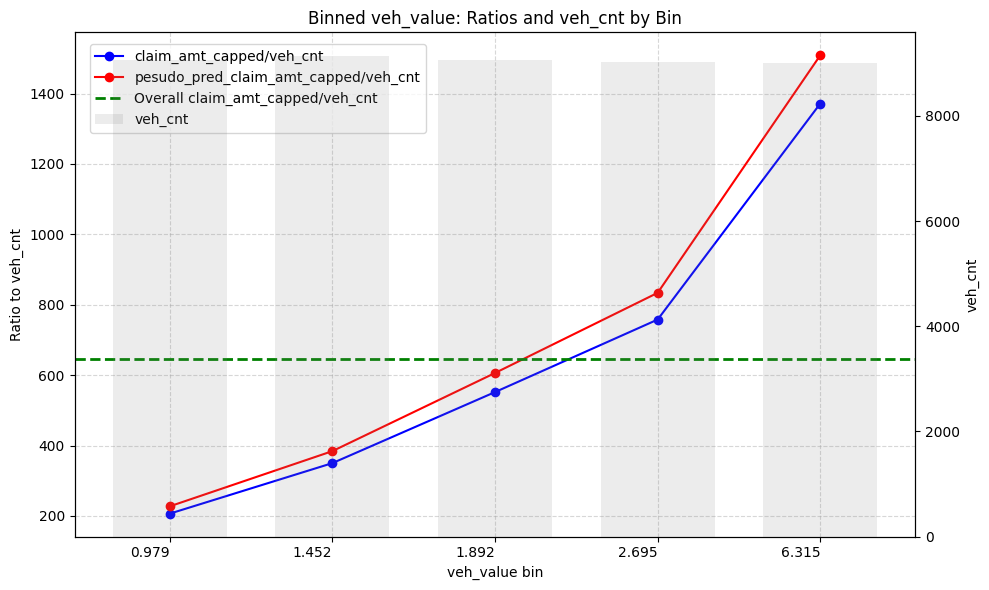

In [94]:
# Example usage of plot_agg_df
# Assume you have already created agg_df using the aggregate() function, and defined pred_var, exp_var, var_1, var_2
plot_agg_df(agg_df, pred_var=pred_var, exp_var=exp_var, var_1=var_1, var_2=var_2)